In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Activation

2021-12-25 14:52:33.607306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-25 14:52:33.607347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
config = yaml.load(
    open("../config.yaml"),
    Loader=yaml.FullLoader
)

In [3]:
# Defaults
seed = int(config['seed'])
np.random.seed(seed)

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (11, 14)

In [4]:
# read in data
data = pd.read_csv(
    './data/raw/risk_factors_cervical_cancer.csv', na_values='?')
print('Shape: ', data.shape)
data.head()

Shape:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


*We can see that there are missing values in the dataset, we first investigate these.*

## Missing Data

In [5]:
# determine missing values per column
missings = np.zeros(data.shape[1])
for colnum in range(data.shape[1]):
    missings[colnum] = data.iloc[:, colnum].isnull().sum()/data.shape[0]

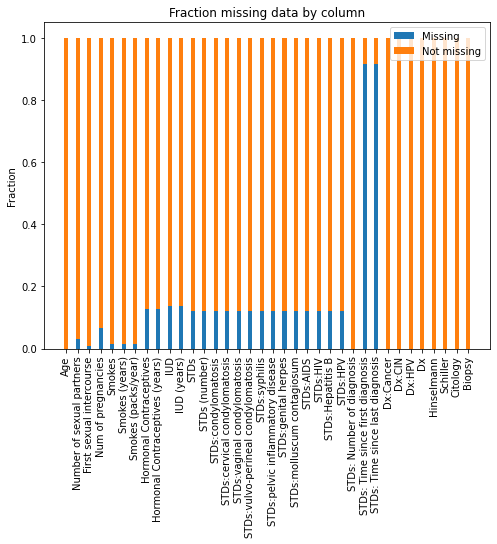

In [6]:
# plot
plt.figure(figsize=(8, 6))
ind = np.arange(len(missings))
width = 0.35
p1 = plt.bar(ind, missings, width)
p2 = plt.bar(ind, 1-missings, width, bottom=missings)
plt.ylabel('Fraction')
plt.title('Fraction missing data by column')
plt.xticks(ind, data.columns.values, rotation=90)
plt.legend((p1[0], p2[0]), ('Missing', 'Not missing'))
plt.show()

In [7]:
# save 'Fraction missing data by column' plot
plt.savefig('./data/processed/col_miss1.png')

<Figure size 792x1008 with 0 Axes>

*We will first drop the two columns with many missing values. We will then investigate two methods of filling the other missing values.*

In [8]:
# drop STD columns as it contains too many missing values
data_drop = data.drop(
    ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'],
    axis=1
)
data_drop.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


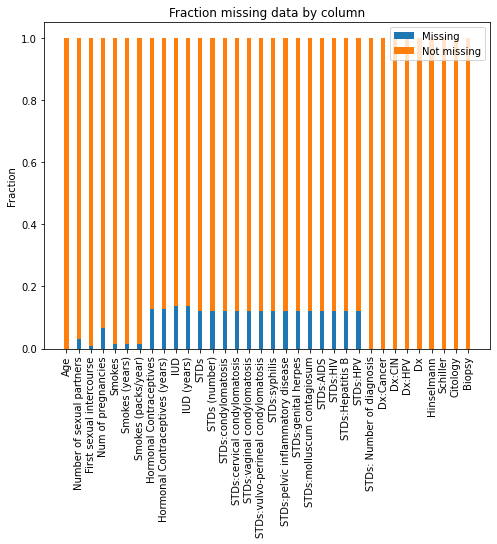

In [9]:
# plot
missings = np.zeros(data_drop.shape[1])
for colnum in range(data_drop.shape[1]):
    missings[colnum] = data_drop.iloc[:, colnum].isnull().sum() / \
        data_drop.shape[0]

plt.figure(figsize=(8, 6))
ind = np.arange(len(missings))
width = 0.35
p1 = plt.bar(ind, missings, width)
p2 = plt.bar(ind, 1-missings, width, bottom=missings)
plt.ylabel('Fraction')
plt.title('Fraction missing data by column')
plt.xticks(ind, data_drop.columns.values, rotation=90)
plt.legend((p1[0], p2[0]), ('Missing', 'Not missing'))
plt.savefig('./data/processed/col_miss2.png')
plt.show()

<Figure size 792x1008 with 0 Axes>

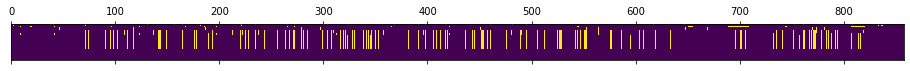

<Figure size 792x1008 with 0 Axes>

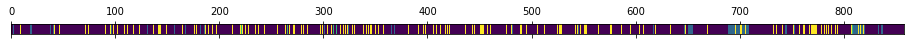

Data shape:  (858, 34)


In [10]:
# plot by sample
missings = np.zeros((data_drop.shape[0], data_drop.shape[1]+1))
for colnum in range(data_drop.shape[1]):
    colcurr = data_drop.iloc[:, colnum]
    missings[:, colnum] = data_drop.iloc[:, colnum].isnull().astype('int')

plt.figure()
plt.matshow(missings.T, cmap='viridis')
plt.yticks([])
plt.savefig('./data/processed/missings1.png')

plt.figure()
summed = np.sum(missings, 1)[:, np.newaxis]
plt.matshow(np.repeat(summed, 10, axis=1).T, cmap='viridis', vmin=0, vmax=3)
plt.yticks([])
# plt.savefig('missings2.png')
plt.show()

print('Data shape: ', data_drop.shape)

In [11]:
# drop extra data rows which contain missing observations
data_drop = data_drop.dropna()

print('Data shape: ', data_drop.shape)

Data shape:  (668, 34)


In [12]:
# train test split
train_ratio = float(config['train_ratio'])
train_id = int(train_ratio * data_drop.shape[0])
idx = data_drop.index.values
np.random.shuffle(idx)

train = data_drop.loc[idx[:train_id], :]
test = data_drop.loc[idx[train_id:], :]

print('Train_Data shape: ', train.shape)
print('Test_Data shape: ', test.shape)

Train_Data shape:  (467, 34)
Test_Data shape:  (201, 34)


In [13]:
# save train and test datasets
train.to_csv('./data/processed/train.csv')
test.to_csv('./data/processed/test.csv')

In [14]:
from modules.plot_util import simple_ax

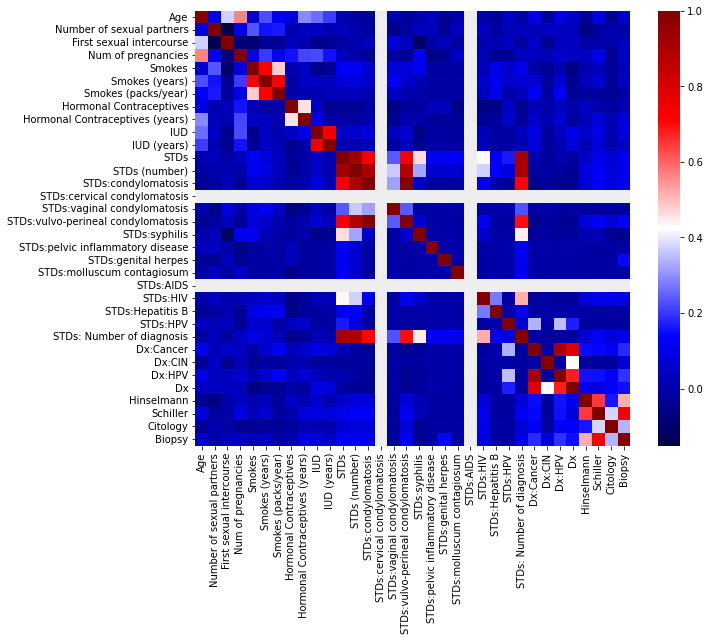

In [15]:
f, a = simple_ax(figsize=(10, 8))
sns.heatmap(data_drop.corr(), vmax=1, square=True, cmap='seismic')
plt.savefig('./data/processed/correlations.png')
plt.show()

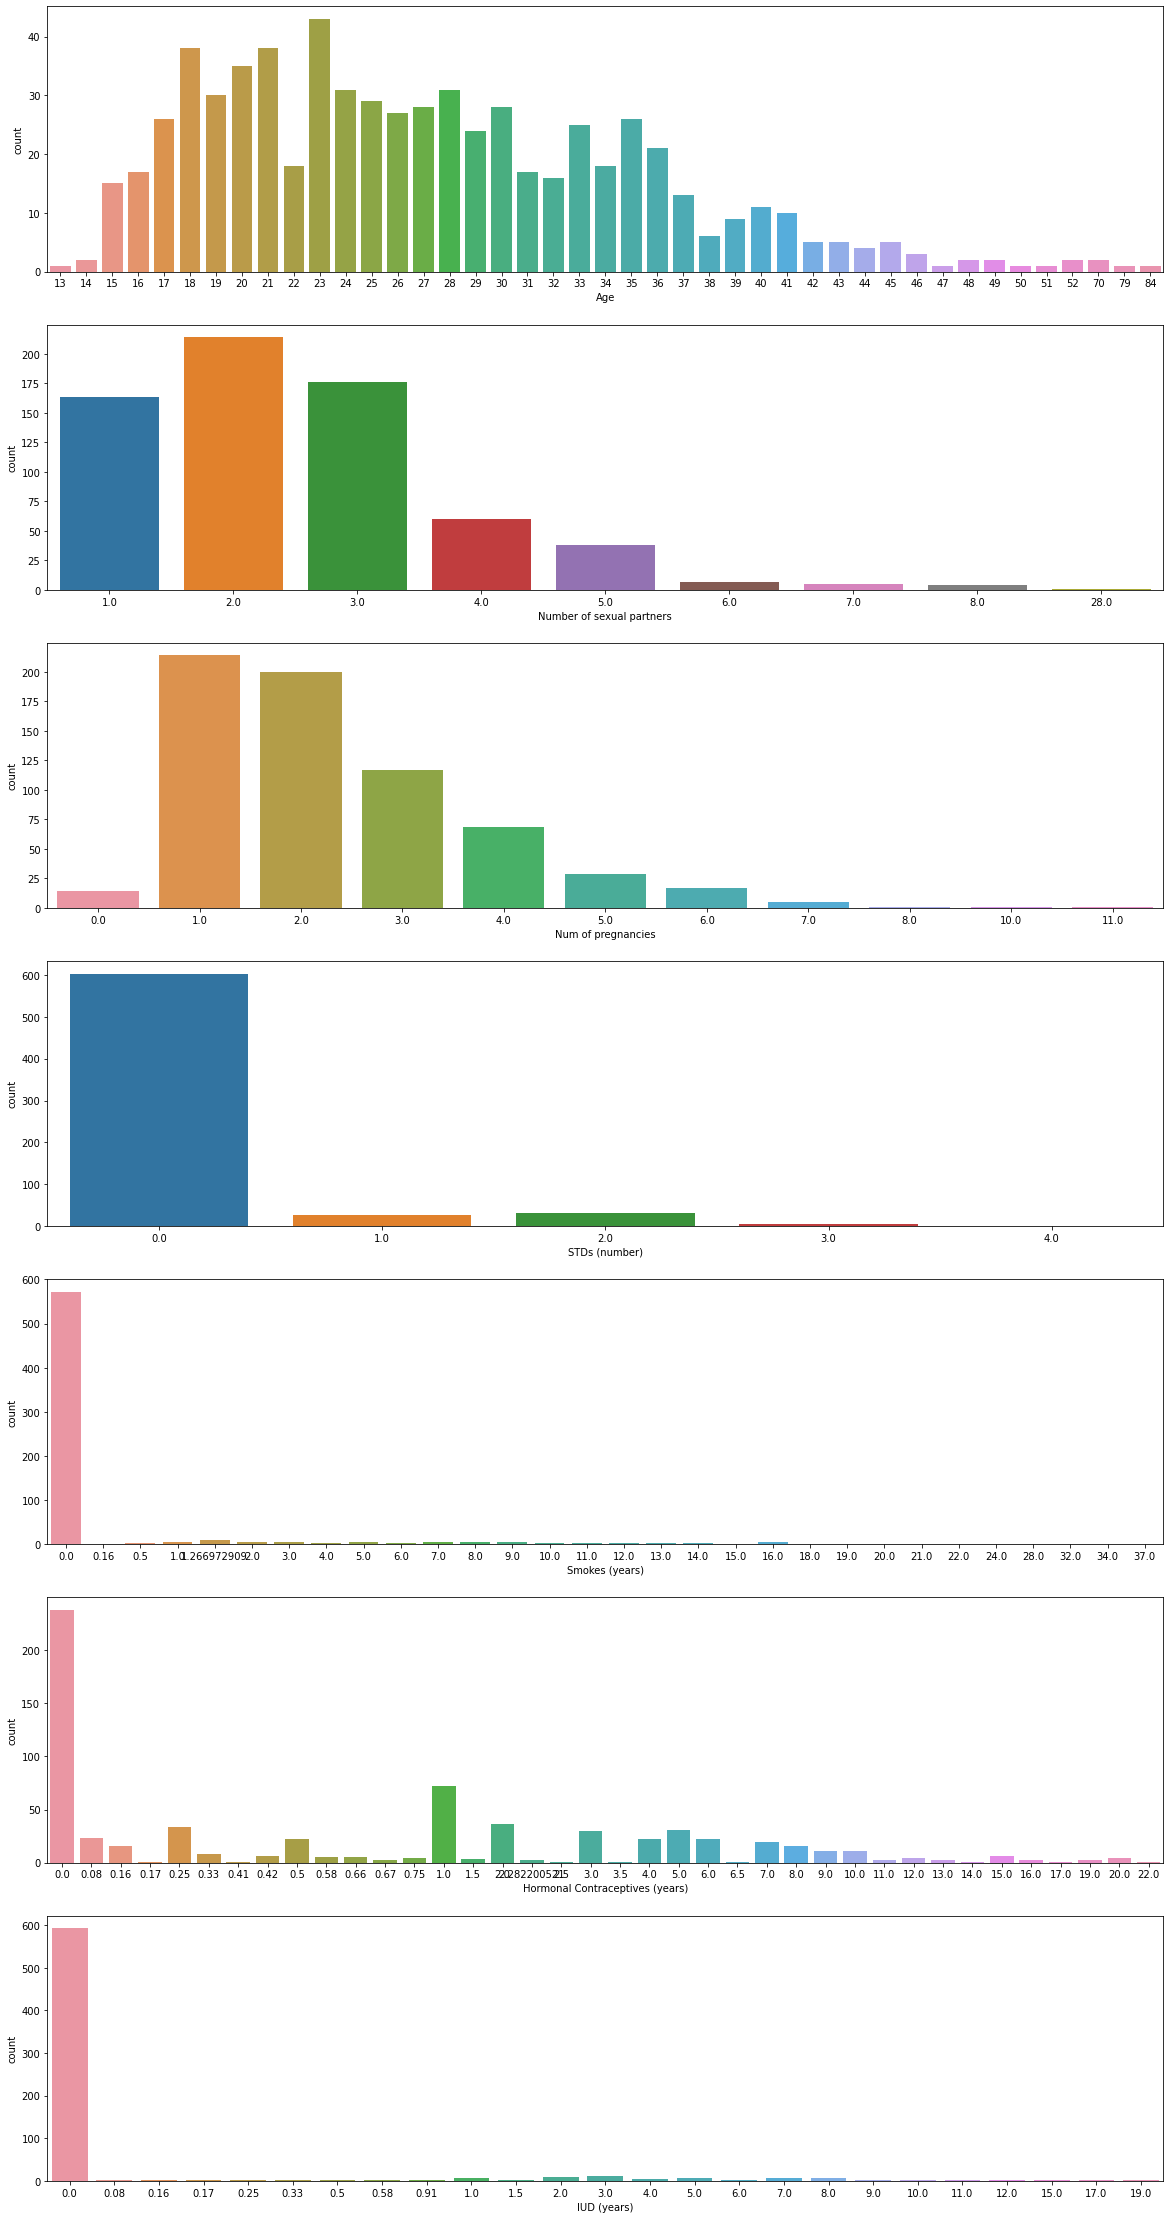

In [16]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(20, 40))
sns.countplot(x=data_drop['Age'], ax=ax[0])
sns.countplot(x=data_drop['Number of sexual partners'], ax=ax[1])
sns.countplot(x=data_drop['Num of pregnancies'], ax=ax[2])
sns.countplot(x=data_drop['STDs (number)'], ax=ax[3])
sns.countplot(x=data_drop['Smokes (years)'], ax=ax[4])
sns.countplot(x=data_drop['Hormonal Contraceptives (years)'], ax=ax[5])
sns.countplot(x=data_drop['IUD (years)'], ax=ax[6])
plt.savefig('./data/processed/data_peek.png')
plt.show()

*Out of all the recommended diagnosis procedures (Hinselmann, Schiller, Citology and Biopsy: target variables) we use recommendation of a biopsy by an oncologist as the metric for potential cancer risk, because biopsy is generally recommended only when there is a significantly high
perceived risk of cancer. By itself, a biopsy is an expensive and invasive procedure and we believe that a
model that captures this information can be valuable to a patient before they choose to undertake this
expensive procedure. *

## Build Neural Network Perceptron Model

In [17]:
X_train = train.iloc[:, :-4].values
y_train = train.iloc[:, -4:].values
X_test = test.iloc[:, :-4].values
y_test = test.iloc[:, -4:].values

print('X_train:', X_train.shape, '| y_train:', y_train.shape)
print('X_test:', X_test.shape, '| y_test:', y_test.shape)

X_train: (467, 30) | y_train: (467, 4)
X_test: (201, 30) | y_test: (201, 4)


In [18]:
y_test[:, 3].sum()

16

In [19]:
from itertools import product
from tqdm import tqdm

In [20]:
param_nodes = [16, 24, 32, 64, 128]
param_weights = [1., 5., 10., 15., 20., 25., 50.]
param_epochs = [100, 200, 300]

parameters = product(param_nodes, param_weights, param_epochs)
parameters_list = sorted(list(parameters))
len(parameters_list)

105

In [21]:
warnings.filterwarnings('ignore')

best = ()
for param in tqdm(parameters_list):
    model = Sequential()
    model.add(Dense(param[0], input_dim=X_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    weights = {0: 1., 1: param[1]}
    history = model.fit(
        X_train, y_train[:, 3], epochs=param[2], class_weight=weights, verbose=0)
    decs = model.predict(X_test)
    roc = roc_curve(y_test[:, 3], decs)
    auc = roc_auc_score(y_test[:, 3], decs)
    if best == () or auc > best[0]:
        best = (auc, roc, history, model, param[0], param[1], param[2])

warnings.filterwarnings('default')

  0%|          | 0/105 [00:00<?, ?it/s]2021-12-25 14:52:40.911872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-25 14:52:40.912014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-25 14:52:40.912073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-25 14:52:40.912110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-25 14:52:40.912146: W tensorflow/stream_ex

In [22]:
(auc, roc, history, model, nodes, weight, epochs) = best
print("Nodes:", nodes, "| Weight:", weight, "| Epochs:", epochs)

Nodes: 16 | Weight: 50.0 | Epochs: 100


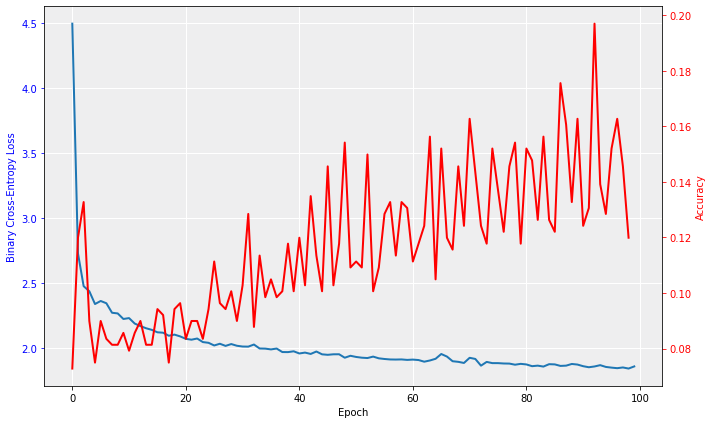

In [23]:
# plot errors
fig, ax1 = simple_ax(figsize=(10, 6))
ax1.plot(history.history['loss'], label='loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross-Entropy Loss', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
plt.plot(history.history['accuracy'][1:], 'r-', label='accuracy', linewidth=2)
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
# plt.savefig('Figures/error2.png')
plt.show()

In [24]:
from modules.plot_util import roc_plot

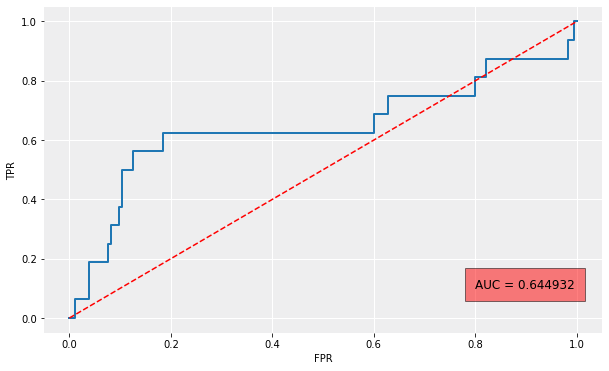

In [25]:
col = 3

decs = model.predict(X_test)
roc = roc_curve(y_test[:, col], decs)
auc = roc_auc_score(y_test[:, col], decs)

roc_plot(roc, auc, 'mlp_roc')

## Logistic Regression

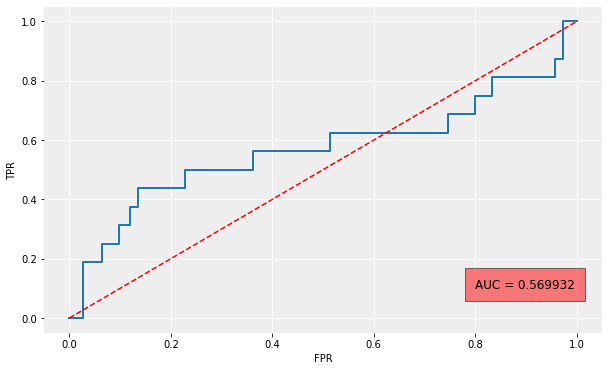

In [26]:
logistic = LogisticRegression(max_iter=400, random_state=seed)
logistic.fit(X_train, y_train[:, col])
decs = logistic.decision_function(X_test)

roc = roc_curve(y_test[:, col], decs)
auc = roc_auc_score(y_test[:, col], decs)

roc_plot(roc, auc, 'logistic_roc')

## Ridge Regression

/home/vsklamm/.local/share/virtualenvs/BTP_ML_in_Healthcare-nL1K_Af5/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


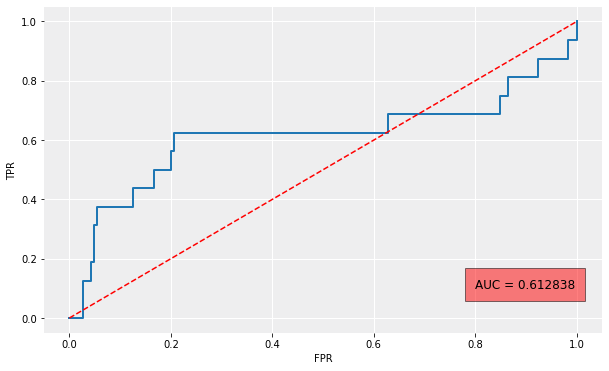

In [27]:
ridge = RidgeClassifier(normalize=True, random_state=seed)
ridge.fit(X_train, y_train[:, col])
decs = ridge.decision_function(X_test)

roc = roc_curve(y_test[:, col], decs)
auc = roc_auc_score(y_test[:, col], decs)

roc_plot(roc, auc, 'ridge_roc')

## Random Forest

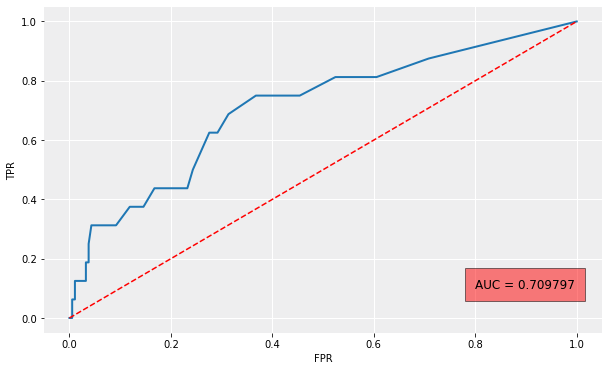

In [28]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train[:, col])
decs = rf.predict_proba(X_test)[:, 1]

roc = roc_curve(y_test[:, col], decs)
auc = roc_auc_score(y_test[:, col], decs)

roc_plot(roc, auc, 'rf_roc')